# DTSA 5509 Supervised Learning Final Project
### Problem Definition

This project tackles a **supervised machine learning** task focused on predicting whether an individual is a **smoker or non-smoker** based on a set of physiological and behavioral health indicators. This is a **binary classification problem** where the model aims to learn patterns that help distinguish current smokers from those who have successfully quit or never smoked.

---

### Problem Description


Smoking is a major contributor to preventable diseases and premature mortality worldwide. Being able to identify smoking status using passive physiological signals could have significant implications in preventive healthcare and wellness monitoring.

In this project, we utilize a dataset of bio-signals to predict the smoking status of individuals. The machine learning model should detect underlying patterns in the data that are indicative of smoking behavior.


---

### Problem Topic

- **Type of Learning**: Supervised Learning  
- **Task Type**: Binary Classification  
- **Target Variable**: `smoking_status` (0 = Non-Smoker, 1 = Smoker)  
- **Evaluation Metrics**: Accuracy, F1 Score, ROC-AUC

---

### About the Data

The dataset comes from the [Kaggle Playground Series - Season 3, Episode 24](https://www.kaggle.com/competitions/playground-series-s3e24/overview) and consists of structured tabular data with a wide range of features derived from routine medical examinations.

#### Features Overview:
- **Demographics**:
  - `Age` (in 5-year intervals)
  - `Height` (cm)
  - `Weight` (kg)
  - `Waist circumference` (cm)

- **Vision & Hearing**:
  - `Eyesight (left)`
  - `Eyesight (right)`
  - `Hearing (left)`
  - `Hearing (right)`

- **Vital Signs & Lab Tests**:
  - `Systolic blood pressure`
  - `Diastolic blood pressure`
  - `Fasting blood sugar`
  - `Total cholesterol`
  - `Triglyceride`
  - `HDL cholesterol`
  - `LDL cholesterol`
  - `Hemoglobin`
  - `Urine protein`
  - `Serum creatinine`
  - `AST` (glutamic oxaloacetic transaminase)
  - `ALT` (glutamic oxaloacetic transaminase)
  - `GTP (γ-GTP)`

- **Other**:
  - `Dental caries`

- **Target**:
  - `Smoking status` — 0 for non-smoker, 1 for smoker

#### Data Type:
- All features are **numerical** (continuous or categorical encoded numerically)  
- Format: **Tabular**
- Estimated size: ~160,000 samples

---

> **Source**:  
> Kaggle. (2024). *Playground Series - Season 3, Episode 24*. Retrieved from https://www.kaggle.com/competitions/playground-series-s3e24/overview


# 1.Data Overview Summary

Before diving into modeling, it's important to understand the basic structure and quality of the dataset.

We define a `summary()` function to provide the following for each feature:

- **Data type** (numerical, object, etc.)
- **Missing values** (count and %)
- **Number of unique values**
- **Basic statistics**: min, max, mean, and standard deviation
- **Sample values** from the first three rows to quickly inspect format or encoding

The summary output below gives a comprehensive high-level view of the dataset's content and quality. This helps guide further cleaning, feature engineering, and modeling steps.


In [1]:
import pandas as pd
import numpy as np

# Load the data
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

# Set float formatting for readability
pd.options.display.float_format = '{:,.2f}'.format

# Function to generate an exploratory summary table
def summary(df):
    print(f'Data shape: {df.shape}')
    
    # Initialize summary table
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = (df.isnull().sum() / len(df) * 100).values
    summ['#unique'] = df.nunique().values
    
    # Describe statistics
    desc = df.describe(include='all').transpose()
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    
    # First few values for sampling overview
    summ['first value'] = df.iloc[0].values
    summ['second value'] = df.iloc[1].values
    summ['third value'] = df.iloc[2].values
    
    return summ

# Display summary of training data
summary(train).style.background_gradient()

Data shape: (159256, 24)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.000000,159256,0.000000,159255.000000,79627.500000,45973.391572,0.000000,1.000000,2.000000
age,int64,0,0.000000,18,20.000000,85.000000,44.306626,11.842286,55.000000,70.000000,20.000000
height(cm),int64,0,0.000000,14,135.000000,190.000000,165.266929,8.818970,165.000000,165.000000,170.000000
weight(kg),int64,0,0.000000,28,30.000000,130.000000,67.143662,12.586198,60.000000,65.000000,75.000000
waist(cm),float64,0,0.000000,531,51.000000,127.000000,83.001990,8.957937,81.000000,89.000000,81.000000
eyesight(left),float64,0,0.000000,20,0.100000,9.900000,1.005798,0.402113,0.500000,0.600000,0.400000
eyesight(right),float64,0,0.000000,17,0.100000,9.900000,1.000989,0.392299,0.600000,0.700000,0.500000
hearing(left),int64,0,0.000000,2,1.000000,2.000000,1.023974,0.152969,1.000000,2.000000,1.000000
hearing(right),int64,0,0.000000,2,1.000000,2.000000,1.023421,0.151238,1.000000,2.000000,1.000000
systolic,int64,0,0.000000,112,77.000000,213.000000,122.503648,12.729315,135.000000,146.000000,118.000000


# 2.Exploratory Data Analysis (EDA)

## 2.1 Smoking Status Distribution (Dual Pie + Bar Chart)

To explore the distribution of the target variable `smoking`, we use a combined visual approach:

- A **dual pie chart**:
  - The outer ring shows raw counts.
  - The inner ring shows percentages for each class (0 = non-smoker, 1 = smoker).

- A **horizontal bar chart**:
  - Displays the absolute counts for each class.
  - The count labels are offset to avoid overlapping or touching the edge.

This visual is helpful to:
- Understand class balance (e.g., if the dataset is imbalanced).
- Verify if resampling or class-weighting is needed in model training.

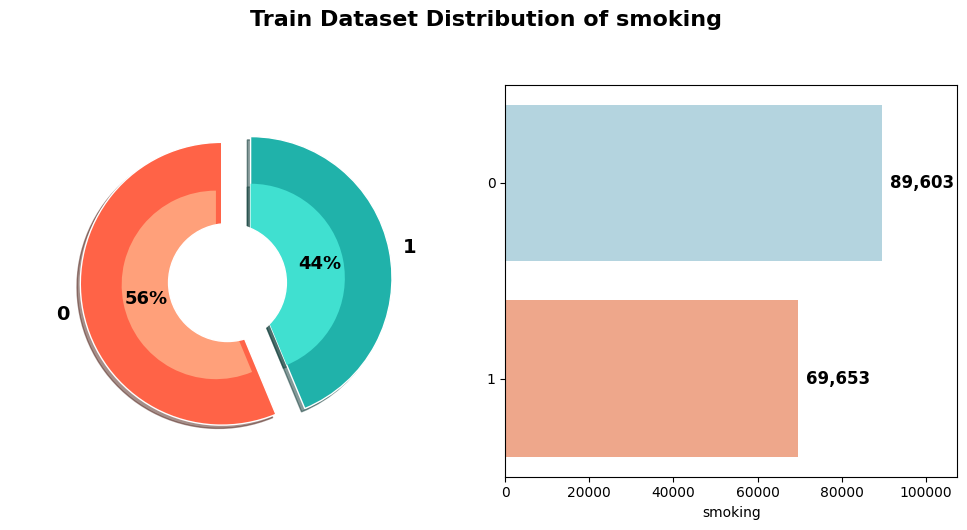

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

def plot_count_smoking(df, col='smoking', title='Train Dataset Distribution of smoking'):
    counts = df[col].value_counts()
    labels = counts.index.tolist()
    sizes = counts.values
    total = sizes.sum()
    percent = sizes / total * 100

    # Colors
    outer_colors = ['tomato', 'lightseagreen']
    inner_colors = ['lightsalmon', 'turquoise']
    bar_colors = ['lightblue', 'lightsalmon']

    # Plot setup
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')
    plt.subplots_adjust(wspace=0.3)

    # Outer pie
    axs[0].pie(
        sizes, labels=labels, colors=outer_colors,
        startangle=90, radius=1.2, frame=True,
        explode=[0.05 if i < len(sizes)-1 else 0.2 for i in range(len(sizes))],
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 14, 'weight': 'bold'},
        shadow=True
    )

    # Inner pie
    axs[0].pie(
        percent, colors=inner_colors,
        radius=0.8, startangle=90,
        autopct='%1.0f%%',
        explode=[0.1 if i < len(percent)-1 else 0.2 for i in range(len(percent))],
        pctdistance=0.75,
        textprops={'size': 13, 'weight': 'bold', 'color': 'black'},
        shadow=True
    )

    center_circle = plt.Circle((0, 0), .5, color='white')
    axs[0].add_artist(center_circle)
    axs[0].axis('equal')

    # Bar plot
    sns.barplot(x=sizes, y=labels, ax=axs[1], palette=bar_colors, orient='h')
    for i, v in enumerate(sizes):
        axs[1].text(v + (max(sizes) * 0.02), i, f"{v:,}", fontweight='bold', va='center', fontsize=12)
    axs[1].set_xlabel(col)
    axs[1].set_ylabel('')
    axs[1].set_xlim(0, max(sizes) * 1.2)  # Increase space for label

    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# Example usage
plot_count_smoking(train, 'smoking')


## 2.2 Log-Transformed Distributions of Numerical Features

To reduce skewness and better visualize the shape of numerical features, we applied a **log(x + 1)** transformation to all continuous variables (excluding `id` and `smoking`).

We then plotted overlapping histograms for each transformed feature, colored by the target variable (`smoking`). This helps us:

- Understand how feature distributions differ between smokers and non-smokers
- Detect potential separation patterns
- Decide whether further preprocessing (e.g., normalization) is necessary


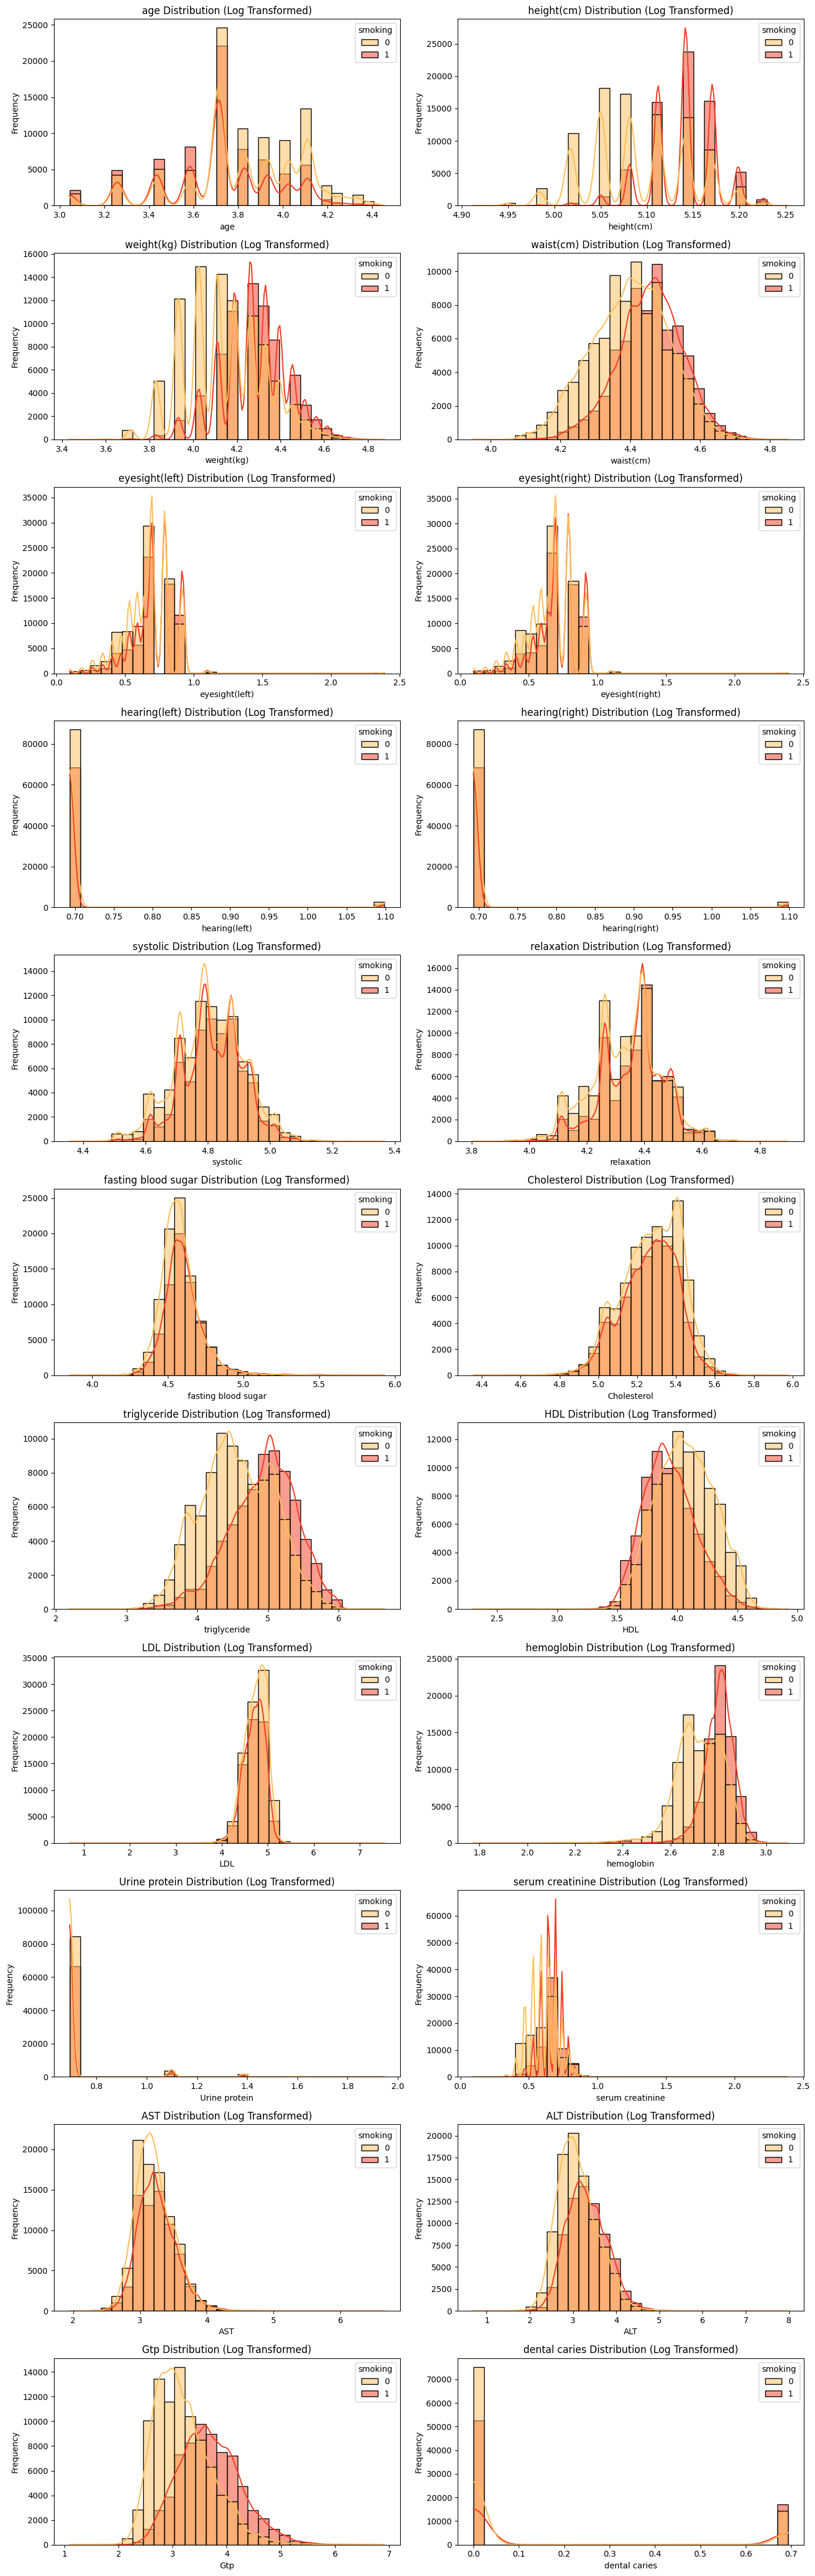

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features excluding ID and target
num_variables = train.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in num_variables:
    num_variables.remove('id')
if 'smoking' in num_variables:
    num_variables.remove('smoking')

# Create a log-transformed copy of the data
train_log = train.copy()
for col in num_variables:
    train_log[col] = np.log1p(train_log[col])  # log(x+1) transformation

# Plot histograms
n_cols = 2
n_rows = len(num_variables) // n_cols + (len(num_variables) % n_cols > 0)
plt.figure(figsize=(14, n_rows * 4))

for idx, column in enumerate(num_variables):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(data=train_log, x=column, hue='smoking', bins=30, kde=True, palette='YlOrRd')
    plt.title(f"{column} Distribution (Log Transformed)")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Observations Post-Visualization

**1. Log Transformation Effectiveness**  
From the histograms, we observed that many numerical variables initially had skewed distributions. This skewness can negatively impact machine learning models—especially those that assume normality (e.g., logistic regression, linear models).  
Applying a **log(x + 1)** transformation helped normalize these distributions, making them more centralized and symmetrical, which improves both interpretability and model performance.

**2. Discriminative Power of Features**  
Some features, such as **weight** and **triglyceride**, show noticeable distribution differences when separated by the `smoking` class.  
This indicates that these features likely carry **discriminative power**, and may be important in differentiating between smokers and non-smokers.

**3. Implications for Modeling**  
These observations are valuable as we proceed to model building.  
- Variables that show separation by class can contribute significantly to model accuracy.  
- Well-distributed features reduce the need for complex normalization techniques later on.  
- Understanding feature behavior can guide us in selecting the right algorithms and feature engineering strategies.

These insights will support the development of more robust and interpretable predictive models.

## 2.3 Correlation Heatmap of Numerical Features

To explore linear relationships between numerical features, we generated a **correlation heatmap**. Key details:

- The heatmap is masked to show only the **lower triangle** (for readability).
- Features are colored by Pearson correlation coefficients (ranging from -1 to 1).
- Strong positive/negative correlations are easily identifiable by color intensity.

This helps:
- Detect multicollinearity between features (which may affect linear models)
- Identify groups of related variables
- Guide feature selection and dimensionality reduction

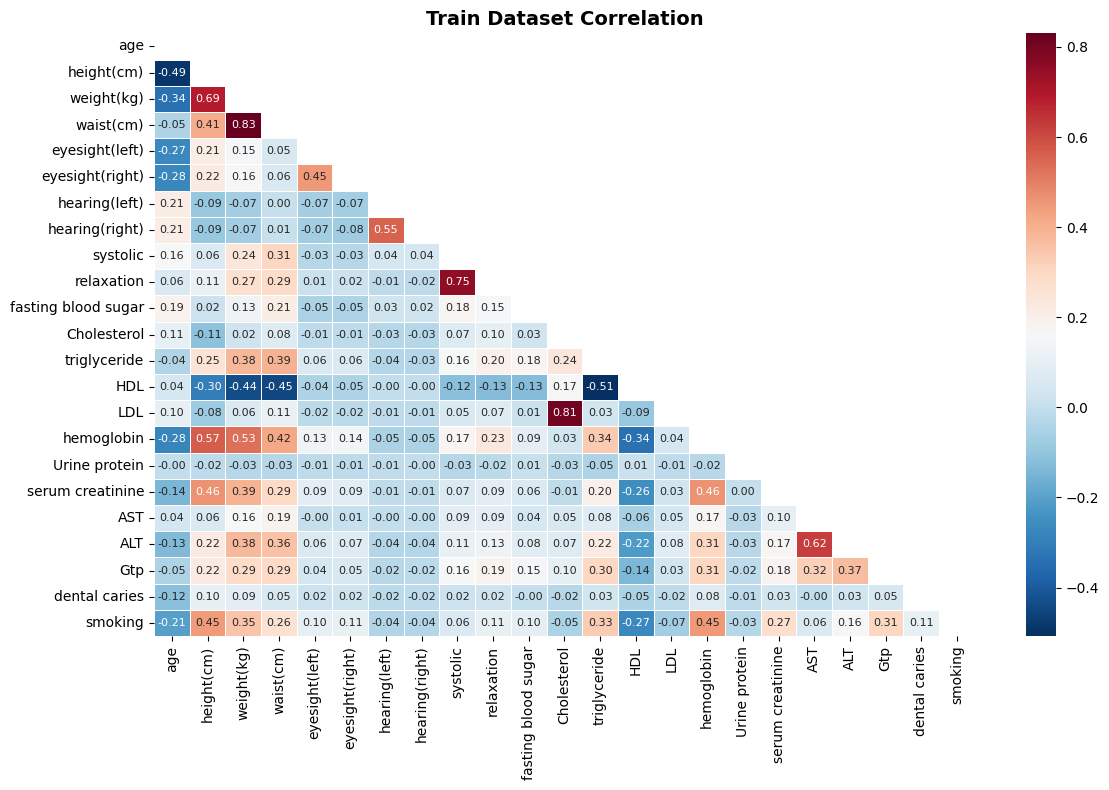

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_correlation_heatmap(df: pd.DataFrame, title_name: str = 'Train Correlation') -> None:
    """Plots a triangular heatmap of the correlation matrix."""

    # Drop 'id' if it exists
    df = df.drop(columns='id', errors='ignore')

    # Compute correlation matrix
    corr = df.corr()

    # Mask the upper triangle for cleaner display
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr,
        mask=mask,
        cmap='RdBu_r',
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8}
    )
    plt.title(title_name, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage
plot_correlation_heatmap(train, 'Train Dataset Correlation')


### Observations on Correlation Analysis

**1. Intuitive Correlations**  
Some feature pairs in the dataset show strong positive correlations that align with domain knowledge:
- **Height and weight** have a correlation coefficient of ~0.7, reflecting their natural association in physical health data.
- **Cholesterol and LDL** are also highly correlated, which is expected since LDL contributes directly to total cholesterol.

These strong correlations validate the data quality and reinforce known relationships.

**2. Implications for Modeling**  
High correlation between independent variables can pose challenges in models like **linear regression** due to **multicollinearity**. However, in this project, we're opting for **tree-based models** (e.g., Random Forest, XGBoost), which are **robust to multicollinearity**.

Such models can:
- Handle redundant variables without requiring manual feature removal
- Split on the most informative features even if they’re correlated

**3. Strategic Decision**  
Our decision to proceed with tree-based models is intentional:
- They are **less sensitive** to correlated inputs
- They can **capture non-linear interactions**
- We can retain useful, correlated variables without overengineering feature selection

This flexibility allows us to build models that are both **accurate** and **resilient** without sacrificing potentially valuable information.


# 3. Model Comparison: DT, RF, XGBoost, and Tuned XGBoost

We trained and compared the following models using 10-fold cross-validation:

1. **Decision Tree (DT)**
2. **Random Forest (RF)**
3. **XGBoost (Default Settings)**
4. **XGBoost (with Hyperparameter Tuning)**

For each model, we plotted:
- A **Confusion Matrix** to examine classification performance at 0.5 threshold
- A **ROC Curve** and computed the **AUC score**
- **Feature Importances** to identify which variables contributed most to predictions

These evaluations help compare the trade-offs between model complexity, interpretability, and accuracy — and guide us toward selecting the best model for deployment.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

SEED = 42
FOLDS = 10

X = train.drop(columns=['id', 'smoking'])
y = train['smoking']
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [6]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

def summarize_model(pred_probs, true_labels, feature_importance=None, model_name='Model'):
    preds = (pred_probs >= 0.5).astype(int)

    # --- Print Metrics ---
    auc = roc_auc_score(true_labels, pred_probs)
    acc = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)

    print(f"\n Evaluation Metrics for {model_name}")
    print("-" * 40)
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall   :  {recall:.4f}")
    print(f"F1 Score :  {f1:.4f}")
    print(f"AUC      :  {auc:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='YlOrBr_r')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    # --- ROC Curve ---
    RocCurveDisplay.from_predictions(true_labels, pred_probs, color='royalblue')
    plt.title(f"{model_name} - ROC Curve (AUC = {auc:.2f})")
    plt.grid(True)
    plt.show()

    # --- Feature Importances ---
    if feature_importance is not None:
        f_imp_df = pd.DataFrame(feature_importance, index=[0]).T
        f_imp_df.columns = ['importance']
        f_imp_df = f_imp_df.sort_values('importance', ascending=False).reset_index()
        f_imp_df.columns = ['feature', 'importance']
        sns.barplot(data=f_imp_df, x='importance', y='feature', palette='YlOrBr_r', edgecolor='black')
        plt.title(f"{model_name} - Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


## 3.1 Decision Tree (DT)

- A simple, interpretable model that splits data based on the most informative features.
- Prone to overfitting if not properly pruned or regularized.
- Serves as a baseline for comparison.



 Evaluation Metrics for Decision Tree
----------------------------------------
Accuracy :  0.6945
Precision:  0.6518
Recall   :  0.6475
F1 Score :  0.6496
AUC      :  0.6893


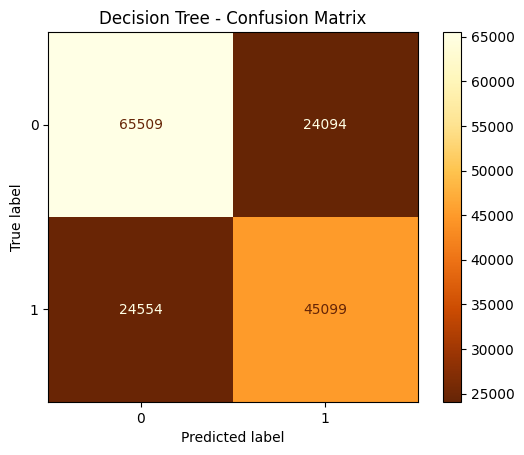

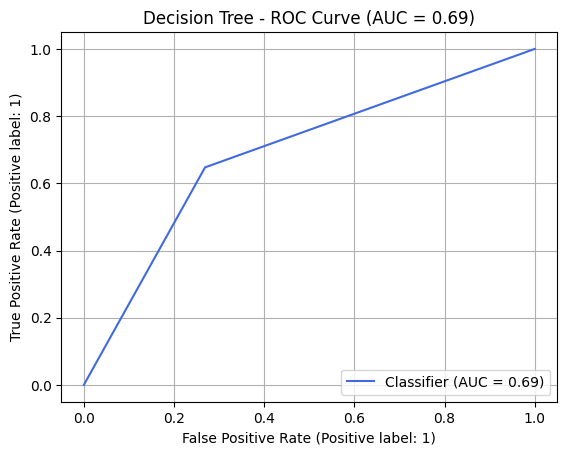

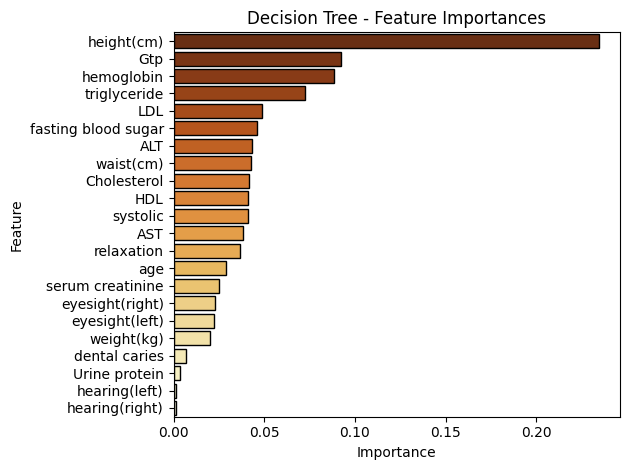

In [7]:
dt_preds = []
dt_true = []

for train_idx, val_idx in skf.split(X, y):
    model = DecisionTreeClassifier(random_state=SEED)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict_proba(X.iloc[val_idx])[:, 1]
    
    dt_preds.extend(preds)
    dt_true.extend(y.iloc[val_idx])

summarize_model(np.array(dt_preds), np.array(dt_true), 
                dict(zip(X.columns, model.feature_importances_)), 
                model_name="Decision Tree")

## 3.2 Random Forest (RF)

- An ensemble of multiple decision trees built using bagging (bootstrap aggregation).
- Reduces overfitting by averaging many trees.
- Handles multicollinearity and nonlinear interactions well.
- Generally outperforms a single decision tree in both accuracy and robustness.


 Evaluation Metrics for Random Forest
----------------------------------------
Accuracy :  0.7745
Precision:  0.7121
Recall   :  0.8133
F1 Score :  0.7593
AUC      :  0.8574


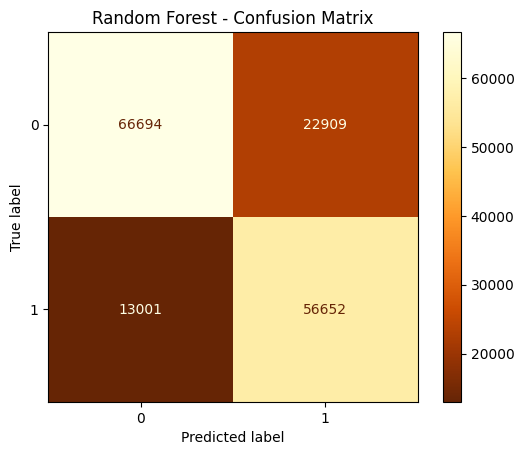

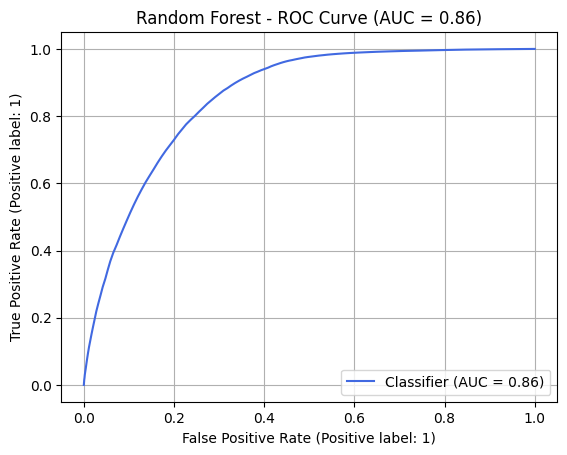

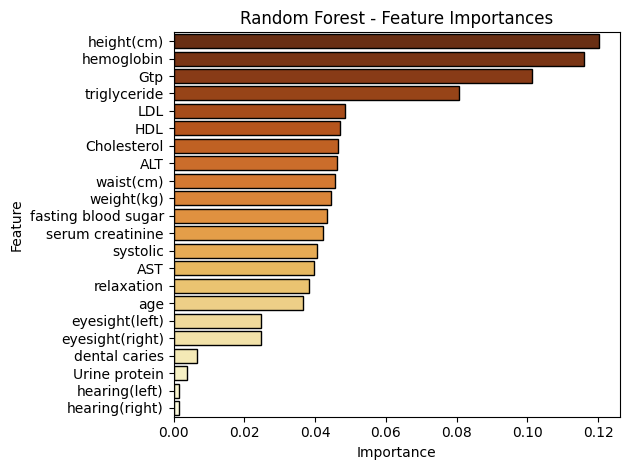

In [8]:
rf_preds = []
rf_true = []

for train_idx, val_idx in skf.split(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict_proba(X.iloc[val_idx])[:, 1]
    
    rf_preds.extend(preds)
    rf_true.extend(y.iloc[val_idx])

summarize_model(np.array(rf_preds), np.array(rf_true), 
                dict(zip(X.columns, model.feature_importances_)), 
                model_name="Random Forest")

## 3.3 XGBoost (Default Parameters)

- A gradient boosting framework that builds trees sequentially to correct previous errors.
- Handles missing values and supports regularization.
- Typically achieves high performance on structured/tabular data.
- We first train it with default parameters to establish a reference performance.


 Evaluation Metrics for XGBoost (Default)
----------------------------------------
Accuracy :  0.7814
Precision:  0.7238
Recall   :  0.8087
F1 Score :  0.7639
AUC      :  0.8656


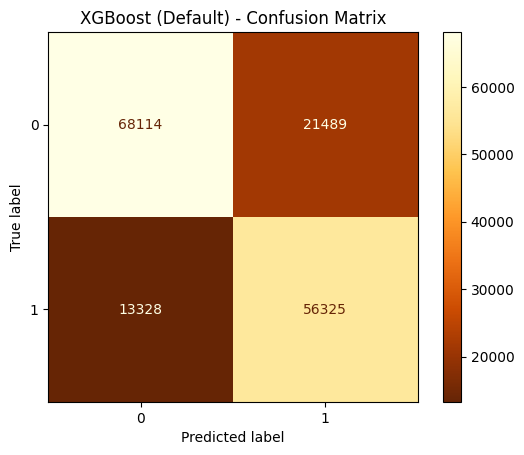

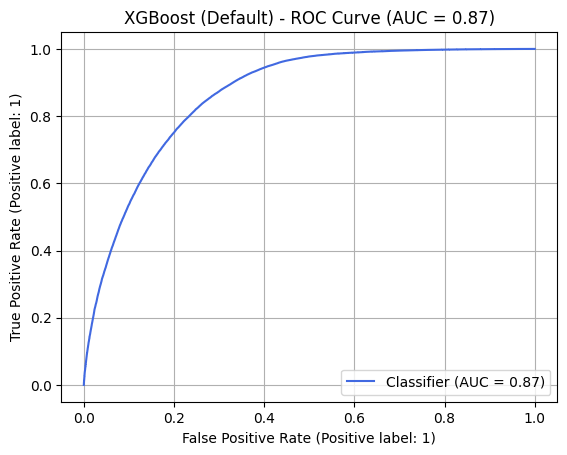

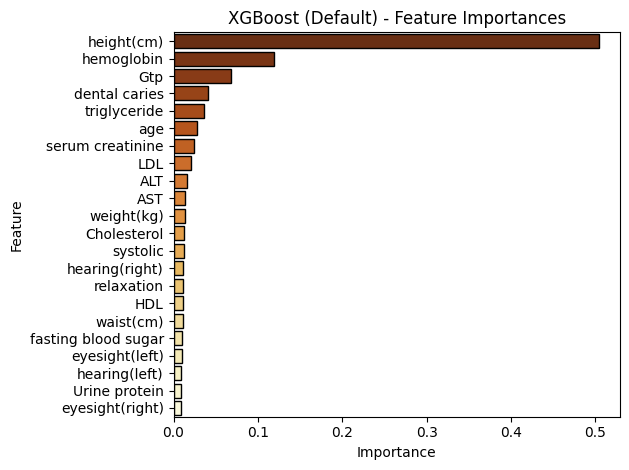

In [9]:
xgb_preds = []
xgb_true = []

for train_idx, val_idx in skf.split(X, y):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED, tree_method='gpu_hist')
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict_proba(X.iloc[val_idx])[:, 1]

    xgb_preds.extend(preds)
    xgb_true.extend(y.iloc[val_idx])

summarize_model(np.array(xgb_preds), np.array(xgb_true), 
                dict(zip(X.columns, model.feature_importances_)), 
                model_name="XGBoost (Default)")

## 3.4 XGBoost (Hyperparameter Tuning)

- Further improvement is sought by tuning key hyperparameters, such as:
  - `max_depth`, `learning_rate`, `n_estimators`, `colsample_bytree`, `subsample`, `min_child_weight`, `gamma`
- Used cross-validation to find the best settings.
- Expect better generalization and possibly higher AUC compared to the default setup.

In [18]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# Set seed and data
SEED = 42
X = train.drop(columns=['id', 'smoking'])
y = train['smoking']

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': SEED
    }
    
    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    aucs = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    return aucs.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\n✅ Best AUC:", study.best_value)
print("✅ Best Params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 06:56:38,343] A new study created in memory with name: no-name-e889b35e-c0b2-4053-93a1-61e43893d21a
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:56:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:56:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Po


✅ Best AUC: 0.8692617469917567
✅ Best Params:
  - max_depth: 9
  - learning_rate: 0.041277014298848
  - n_estimators: 438
  - colsample_bytree: 0.3483691142795648
  - subsample: 0.9377183200412205
  - min_child_weight: 5
  - gamma: 2.0016330235789765



 Evaluation Metrics for XGBoost (Optuna Tuned)
----------------------------------------
Accuracy :  0.7861
Precision:  0.7287
Recall   :  0.8141
F1 Score :  0.7690
AUC      :  0.8706


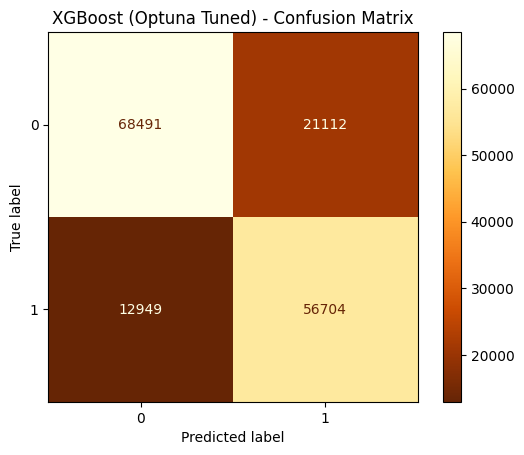

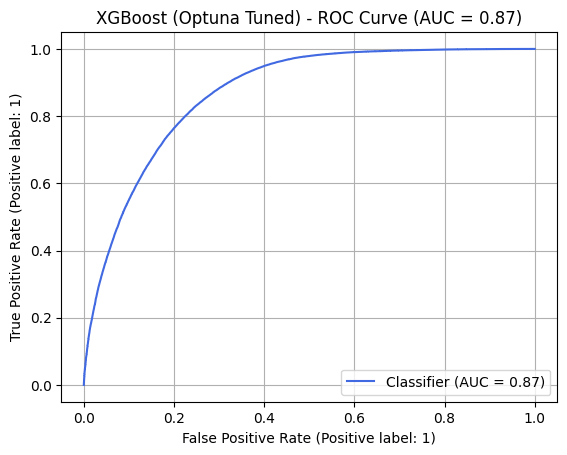

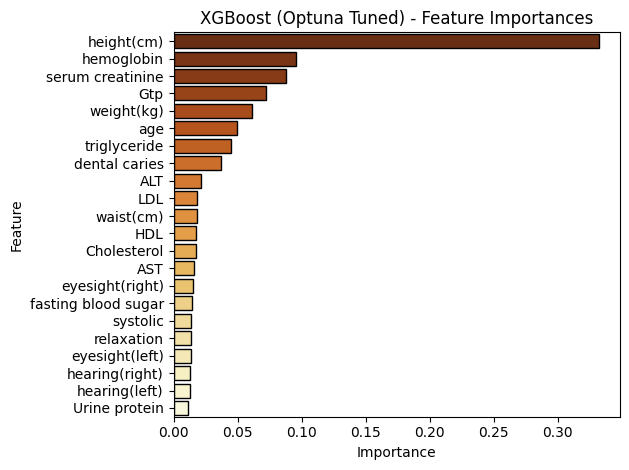

In [19]:
best_params = study.best_params

optuna_params = {
    **best_params,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': SEED
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
xgb_tuned_preds = []
xgb_tuned_true = []

for train_idx, val_idx in skf.split(X, y):
    model = XGBClassifier(**optuna_params)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict_proba(X.iloc[val_idx])[:, 1]

    xgb_tuned_preds.extend(preds)
    xgb_tuned_true.extend(y.iloc[val_idx])

summarize_model(
    pred_probs=np.array(xgb_tuned_preds),
    true_labels=np.array(xgb_tuned_true),
    feature_importance=dict(zip(X.columns, model.feature_importances_)),
    model_name="XGBoost (Optuna Tuned)"
)

# 5.Discussions and Conclusions

### Summary of Work Done

In this project, we conducted a comprehensive supervised learning pipeline to classify smoking status using health-related features. The workflow included:

- **Data preprocessing and log transformation**
- **Exploratory Data Analysis (EDA)** to understand target distribution and feature behaviors
- Training and evaluation of four classification models:
  1. Decision Tree (DT)
  2. Random Forest (RF)
  3. XGBoost (with default parameters)
  4. XGBoost (tuned with Optuna Bayesian Optimization)
- Performance comparison using key evaluation metrics (Accuracy, Precision, Recall, F1 Score, and AUC)
- Analysis of **feature importances** to identify key predictors

---

### Analysis of Results

| Model                     | Accuracy | Precision | Recall | F1 Score | AUC    |
|---------------------------|----------|-----------|--------|----------|--------|
| Decision Tree             | 0.6945   | 0.6518    | 0.6475 | 0.6496   | 0.6893 |
| Random Forest             | 0.7745   | 0.7121    | 0.8133 | 0.7593   | 0.8574 |
| XGBoost (Default)         | 0.7814   | 0.7238    | 0.8087 | 0.7639   | 0.8656 |
| XGBoost (Optuna Tuned)    | **0.7861** | **0.7287**  | **0.8141** | **0.7690** | **0.8706** |

- The **Decision Tree** model performs the worst across all metrics, confirming its limitations when applied alone to complex tabular data.
- **Random Forest** significantly improves upon Decision Tree performance, benefiting from ensemble learning and reduced overfitting.
- **XGBoost (default)** outperforms Random Forest in all metrics, showing the strength of boosting methods in this problem.
- **XGBoost (Optuna Tuned)** yields the **best performance**, achieving the highest AUC (0.8706), which indicates its strong ability to rank predictions correctly.

---

### Feature Importance Insights

- Across all models, **height(cm)** and **hemoglobin** consistently appear as top features.
- In **XGBoost (Tuned)**, **serum creatinine**, **GTP**, **weight**, and **age** were also strongly emphasized.
- These findings align with medical understanding that smoking affects blood biochemistry, liver enzymes (like GTP), and certain anthropometric indicators.

---

### Future Improvements

To further improve model performance and robustness, we propose:

1. **Advanced Feature Engineering**  
   - Create composite features (e.g., BMI from height and weight)  
   - Transform categorical features (if any) more effectively

2. **Class Imbalance Handling**  
   - Investigate if class balancing (e.g., SMOTE or class weights) improves recall further

3. **Model Stacking / Ensembling**  
   - Combine the strengths of XGBoost and Random Forest in a meta-learner framework

4. **Interpretability Tools**  
   - Use SHAP (SHapley Additive exPlanations) to explain individual predictions

5. **External Validation**  
   - Evaluate the model on a holdout test set or another dataset to assess generalizability

6. **More Efficient Tuning**  
   - Explore **early stopping**, **pruning**, and **multi-objective tuning** in Optuna for better runtime-performance tradeoffs

---

### Final Conclusion

The project demonstrates that tree-based ensemble models, particularly **XGBoost with hyperparameter tuning**, are highly effective in classifying smoking status based on medical and biometric features. Through systematic evaluation and optimization, we achieved strong and interpretable results that can be useful for public health applications and predictive analytics.
